# Monte-Carlo method for our refrigerator model/demon model


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Iterable, Optional
from dataclasses import dataclass
from datetime import datetime

In [2]:
# Constants
k_B = 1.0  # Boltzmann constant

@dataclass
class PhysicalParams:
    deltaE: float = 1.0  # Energy difference between states
    gamma: float = 1.0  # Characteristic rate
    sigma: float = 0.0 # T_H factor
    omega: float = 0.0 # T_C factor
    epsilon: float = 0.0 # Temperature difference factor
    T_H: float = 0.0  # Hot reservoir temperature
    T_C: float = 0.0  # Cold reservoir temperature
    beta_H: float = 0.0  # Inverse temperature of hot reservoir
    beta_C: float = 0.0  # Inverse temperature of cold reservoir

    def __post_init__(self):
        if (self.T_H == 0 and self.T_C == 0) and (self.sigma == 0 and self.omega == 0 ):
            raise ValueError("Either T_H and T_C or sigma and omega must be given.")
        elif self.T_H != 0 and self.T_C != 0:
            self.beta_H = 1 / (k_B * self.T_H)
            self.beta_C = 1 / (k_B * self.T_C)
            self.sigma = np.tanh(self.beta_H * self.deltaE / 2)
            self.omega = np.tanh(self.beta_C * self.deltaE / 2)
            self.epsilon = (self.omega - self.sigma) / (1 - self.sigma * self.omega)
        elif self.sigma != 0 and self.omega != 0:
            self.epsilon = (self.omega - self.sigma) / (1 - self.sigma * self.omega)
            self.beta_H = (2 / self.deltaE) * np.arctanh(self.sigma) / k_B
            self.beta_C = (2 / self.deltaE) * np.arctanh(self.omega) / k_B
            self.T_H = 1 / (k_B * self.beta_H)
            self.T_C = 1 / (k_B * self.beta_C)
        self.rates = get_rates(self)

@dataclass
class SimulationParams:
    physical_params: PhysicalParams
    rates: Dict[str, float] = None  # Transition rates
    N: int = 3000  # Number of bits in the tape
    tau: float = 1.0  # Interaction time with each bit
    demon_init: str = "u"  # Initial state of the demon ('u' or 'd')
    delta: float = 0.0  # Initial bias in the tape
    p0: float = 0.5  # Initial probability of bit being 0
    p1: float = 0.5  # Initial probability of bit being 1
    seed: Optional[int] = None  # Random seed for reproducibility

    def post_init(self):
        if self.demon_init not in ['u', 'd']:
            raise ValueError("demon_init must be 'u' or 'd'")
        if self.p0 + self.p1 != 1.0:
            raise ValueError("p0 and p1 must sum to 1")
        if self.delta != 0.0:
            self.p0 = (1 + self.delta) / 2
            self.p1 = (1 - self.delta) / 2
        np.random.seed(datetime.now().microsecond)
        
        self.rates = self.physical_params.rates

def get_rates(params: PhysicalParams) -> Dict[str, float]:
    """Calculate transition rates based on physical parameters.
        Only Allowed Transitions.
    """
    rates = {
        "R_0d_to_1u": (1.0 - params.omega) ,
        "R_1u_to_0d": (1.0 + params.omega),
        "R_0u_to_0d": params.gamma * (1.0 + params.sigma),
        "R_0d_to_0u": params.gamma * (1.0 - params.sigma) ,
        "R_1u_to_1d": params.gamma * (1.0 + params.sigma) ,
        "R_1d_to_1u": params.gamma * (1.0 - params.sigma) ,
    }
    return rates

def get_rates_for_state(state: str, rates: Dict[str, float]) -> Dict[str, float]:
    """Get possible transitions and their rates for a given state.
    Args:
        state (str): Current state (e.g., '0u', '1d').
        rates (Dict[str, float]): Dictionary of all transition rates.
    Returns:
        Dict[str, float]: Possible transitions and their rates.
        example: {'0d': 0.5, '1u': 0.3}
    """
    transitions = {}
    for key, rate in rates.items():
        if key.startswith(f"R_{state}_to_"):
            next_state = key.split("_to_")[1]
            transitions[next_state] = rate
    return transitions

def gillespie_within_window(current_state: str, rates: Dict[str, float], tau: float) -> Tuple[str, float]:
    """Perform Gillespie simulation within a time window tau.
    Args:
        current_state (str): Current state (e.g., '0u', '1d').
        rates (Dict[str, float]): Dictionary of all transitions and their rates.
        tau (float): Time window for the simulation.
    Returns:
        Tuple[str, float]: Final state after time tau and total time elapsed.
    """
    transitions = get_rates_for_state(current_state, rates)
    for rate in transitions.values():
        if rate < 0: 
            print("Negative rate found:", transitions)
            raise ValueError("Transition rates must be non-negative.")
    t = 0.0
    state = current_state
    while True:
        transitions = get_rates_for_state(state, rates)
        if not transitions:
            break  # No possible transitions
        total_rate = sum(transitions.values())
        if total_rate <= 0:
            break  # No transitions can occur
        dt = np.random.exponential(1 / total_rate)
        if t + dt > tau:
            break  # Next event exceeds time window
        t += dt
        rand = np.random.rand()*total_rate
        cumulative_rate = 0.0
        for next_state, rate in transitions.items():
            cumulative_rate += rate
            if rand < cumulative_rate:
                state = next_state
                break
    return state, t

def step_with_fresh_bit_gillespie(current_state: str, params: SimulationParams) -> Tuple[str, str]:
    """Perform one step of the simulation with a fresh bit using Gillespie algorithm.
    Args:
        current_state (str): Current state (e.g., '0u', '1d').
        params (SimulationParams): Simulation parameters.
    Returns:
        Tuple[str, str]: Final state of the demon and the bit after interaction.
    """
    final_state, _ = gillespie_within_window(current_state, params.rates, params.tau)
    demon_state = final_state[1]  # 'u' or 'd'
    bit_state = final_state[0]  # '0' or '1'
    return demon_state, bit_state

In [3]:
def run_simulation_gillespie(params: SimulationParams) -> Dict[str, Dict[str, float]]:
    """Run the full simulation using Gillespie algorithm.
    Args:
        params (SimulationParams): Simulation parameters.
    Returns:
        Dict[str, Dict[str, float]]: Statistics of incoming and outgoing bits.
    """
    params.post_init()
    demon_state = params.demon_init
    incoming_tape = []
    outgoing_tape = []
    incoming_counts = {'0': 0, '1': 0}
    outgoing_counts = {'0': 0, '1': 0}
    for _ in range(params.N):
        # Fresh bit based on initial probabilities
        bit_state = np.random.choice(['0', '1'], p=[params.p0, params.p1])
        incoming_tape.append(bit_state)
        incoming_counts[bit_state] += 1
        current_state = bit_state + demon_state
        demon_state, final_bit_state = step_with_fresh_bit_gillespie(current_state, params)
        outgoing_tape.append(final_bit_state)
        outgoing_counts[final_bit_state] += 1
    total_incoming = incoming_counts['0'] + incoming_counts['1']
    total_outgoing = outgoing_counts['0'] + outgoing_counts['1']
    incoming_probs = {k: v / total_incoming for k, v in incoming_counts.items()}
    outgoing_probs = {k: v / total_outgoing for k, v in outgoing_counts.items()}
    phi_emp = outgoing_probs['1'] - incoming_probs['1']
    return {
        "incoming": incoming_probs,
        "outgoing": outgoing_probs,
        "phi_emp": phi_emp,
    }


In [4]:
# Example usage 
phys_params = PhysicalParams(deltaE=1.0, gamma=1.0, T_H=1.6, T_C=1.0)
sim_params = SimulationParams(physical_params=phys_params, N=100000, tau=2.0, demon_init="d", delta=0.9 , seed = 110)
phys_params

PhysicalParams(deltaE=1.0, gamma=1.0, sigma=np.float64(0.3027097293321085), omega=np.float64(0.46211715726000974), epsilon=np.float64(0.18533319990813948), T_H=1.6, T_C=1.0, beta_H=0.625, beta_C=1.0)

In [5]:
run_simulation_gillespie(sim_params)

{'incoming': {'0': 0.95143, '1': 0.04857},
 'outgoing': {'0': 0.7121, '1': 0.2879},
 'phi_emp': 0.23933}

In [144]:
def get_sigma_from_omega_epsilon(omega, epsilon):
    """Given omega and epsilon, compute sigma."""
    if not -1.0 < omega < 1.0:
        raise ValueError("omega must be in (-1, 1)")
    if not -1.0 <= epsilon <= 1.0:
        raise ValueError("epsilon must be in [-1, 1]")
    sigma = (epsilon - omega) / (-1 + epsilon * omega)
    return sigma
def plot_phi_map_gillespie(
    N: int,
    tau: float,
    demon_init: str = "u",
    n_points: int = 50,
    omega = 0.5,
    seed: Optional[int] = None
):
    """
    Plot the information current Φ = p1' - p1 over a matrix of delta and epsilon.
    Uses Gillespie simulation within each window.
    """
    phi_values = [[], []]
    delta_range = np.linspace(-1, 1, n_points, endpoint=True)
    epsilon_range = np.linspace(0, 1, n_points, endpoint=False)
    percentage_comp = 0.0
    for eps in epsilon_range:
        row = []
        for delta in delta_range:
            sigma = get_sigma_from_omega_epsilon(omega, eps)
            phys = PhysicalParams(sigma=sigma, omega=omega, gamma= 1.0)
            sim_params= SimulationParams(physical_params=phys, N=N, tau=1.0, demon_init="d", delta=delta , seed = 110)
            sim_p = run_simulation_gillespie(sim_params)
            row.append(sim_p["phi_emp"])
        percentage_comp += 1.0
        print(f"Completed {percentage_comp / len(epsilon_range) * 100:.1f}%")
        phi_values[0].append(delta)
        phi_values[1].append(row)
    plt.figure(figsize=(8, 6))
    max_abs_phi = max(abs(np.min(phi_values[1])), abs(np.max(phi_values[1])))

    plt.imshow(phi_values[1], extent=(-1, 1, 0, 1), aspect='auto', origin='lower', cmap='bwr', vmin=-max_abs_phi, vmax=max_abs_phi)
    plt.colorbar(label='Φ (Information Current)')
    plt.xlabel('Incoming Bit Bias δ')
    plt.ylabel('Incoming Bit Bias ε')
    plt.title(f'Information Current Φ over δ and ε (ω={omega}, N={N}, τ={tau})')
    return phi_values
    # plt.show()
    

Completed 0.3%
Completed 0.7%
Completed 1.0%
Completed 1.3%
Completed 1.7%
Completed 2.0%
Completed 2.3%
Completed 2.7%
Completed 3.0%
Completed 3.3%
Completed 3.7%
Completed 4.0%
Completed 4.3%
Completed 4.7%
Completed 5.0%
Completed 5.3%
Completed 5.6%
Completed 6.0%
Completed 6.3%
Completed 6.6%
Completed 7.0%
Completed 7.3%
Completed 7.6%
Completed 8.0%
Completed 8.3%
Completed 8.6%
Completed 9.0%
Completed 9.3%
Completed 9.6%
Completed 10.0%
Completed 10.3%
Completed 10.6%
Completed 11.0%
Completed 11.3%
Completed 11.6%
Completed 12.0%
Completed 12.3%
Completed 12.6%
Completed 13.0%
Completed 13.3%
Completed 13.6%
Completed 14.0%
Completed 14.3%
Completed 14.6%
Completed 15.0%
Completed 15.3%
Completed 15.6%
Completed 15.9%
Completed 16.3%
Completed 16.6%
Completed 16.9%
Completed 17.3%
Completed 17.6%
Completed 17.9%
Completed 18.3%
Completed 18.6%
Completed 18.9%
Completed 19.3%
Completed 19.6%
Completed 19.9%
Completed 20.3%
Completed 20.6%
Completed 20.9%
Completed 21.3%
Compl

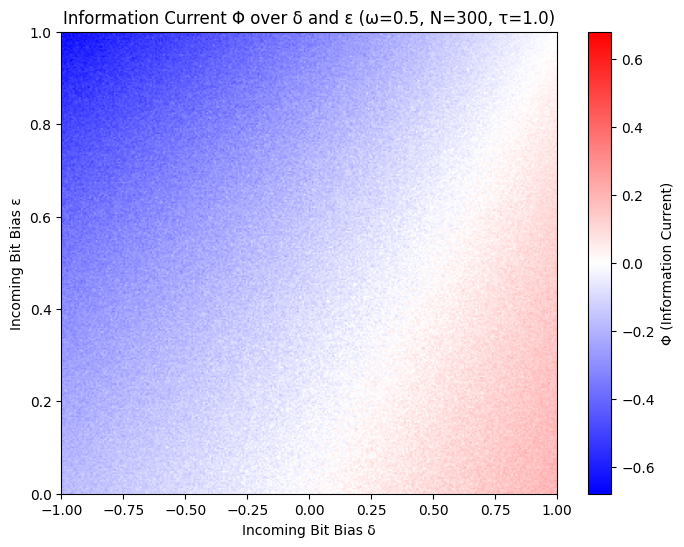

In [148]:
phi_100_100 = plot_phi_map_gillespie(N= 300,tau = 1.0,n_points = 301)

Completed 2.0%
Completed 3.9%
Completed 5.9%
Completed 7.8%
Completed 9.8%
Completed 11.8%
Completed 13.7%
Completed 15.7%
Completed 17.6%
Completed 19.6%
Completed 21.6%
Completed 23.5%
Completed 25.5%
Completed 27.5%
Completed 29.4%
Completed 31.4%
Completed 33.3%
Completed 35.3%
Completed 37.3%
Completed 39.2%
Completed 41.2%
Completed 43.1%
Completed 45.1%
Completed 47.1%
Completed 49.0%
Completed 51.0%
Completed 52.9%
Completed 54.9%
Completed 56.9%
Completed 58.8%
Completed 60.8%
Completed 62.7%
Completed 64.7%
Completed 66.7%
Completed 68.6%
Completed 70.6%
Completed 72.5%
Completed 74.5%
Completed 76.5%
Completed 78.4%
Completed 80.4%
Completed 82.4%
Completed 84.3%
Completed 86.3%
Completed 88.2%
Completed 90.2%
Completed 92.2%
Completed 94.1%
Completed 96.1%
Completed 98.0%
Completed 100.0%


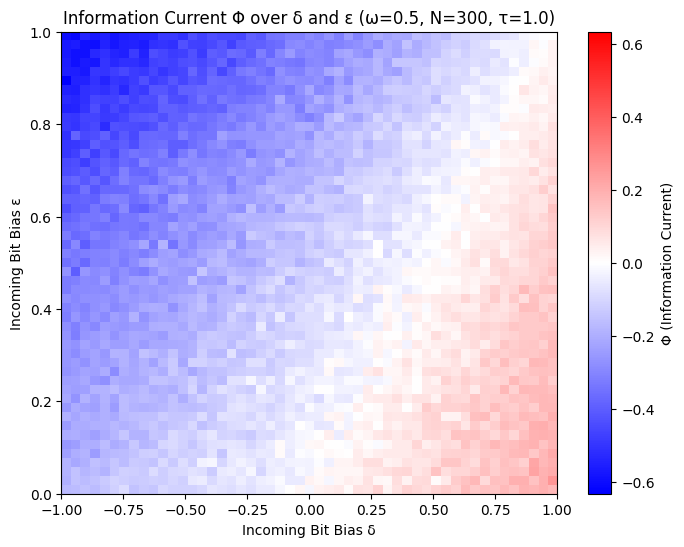

In [149]:
phi_10_10 = plot_phi_map_gillespie(N= 300,tau = 1.0,n_points = 51)
